# MMSR Evaluation Notebook

**Evaluation is run on**
- Random baseline
- Unimodal (audio / lyrics / video)
- Early fusion 
- Late fusion

**Metrics**
It calculated Precision, Recall, MRR, nDCG both with the Jaccard-threshold relevance and with the relevance defintion from the slides. In addition, it considers beyond accuracy metrics coverage and popularity 


## 1) Configuration


In [1]:
import numpy as np

import os
from common import Evaluator, evaluate_system, MODALITIES
from baseline import RandomBaselineRetrievalSystem
from unimodal import UnimodalRetrievalSystem
from early_fusion import EarlyFusionRetrievalSystem
from late_fusion import LateFusionRetrievalSystem
from nn_based import NeuralNetworkBasedRetrievalSystem, NeuralNetworkBasedRetrievalSystemExperiments

import pandas as pd
import matplotlib.pyplot as plt


data_dir = "./data"
k = 10
pop_transform = "log1p"  # or "raw"
evaluator = Evaluator(data_dir, jaccard_relevant_threshold=0.25)


def banner(title: str):
    print("\n" + "=" * 70)
    print(title)
    print("=" * 70)


## 2) Evaluate Random baseline


In [2]:
banner("Random Baseline")
rs = RandomBaselineRetrievalSystem(evaluator, seed=0)
evaluate_system(evaluator, rs, k=k, pop_transform="log1p")  # or pop_transform="raw"



Random Baseline


Evaluating RandomBaselineRetrievalSystem: 100%|██████████| 4148/4148 [00:13<00:00, 314.19track/s]


JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0441 | 0.0741
Recall@10:    0.0022 | 0.0054
MRR@10:       0.1064 | 0.2217
nDCG@10:      0.1009 | 0.0794

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2750
Recall@10:    0.0024 | 0.0023
MRR@10:       0.5784 | 0.3905
nDCG@10:      0.4199 | 0.2829

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9998 (4147 / 4148 songs)
Popularity@10 (log1p):            7.9105 (mean) |  0.4194 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0134 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9212
Popularity p25 / p75:             7.6327 /  8.1987


{'k': 10,
 'coverage': 0.9997589199614272,
 'coverage_count': 4147,
 'pop_mean': 7.910508981815459,
 'pop_std': 0.4194228418903122,
 'catalog_pop': 7.897088940396978,
 'pop_lift': 0.013420041418481077}

## 3) Evaluate Unimodal (each modality)


In [3]:
unimodal_rs = UnimodalRetrievalSystem(data_dir, evaluator)

for modality in MODALITIES:
    banner(f"Unimodal | modality={modality}")
    unimodal_rs.set_modality(modality)
    evaluate_system(evaluator, unimodal_rs, k=k, pop_transform="log1p")


loading...

Unimodal | modality=audio


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 236.55track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1184 | 0.1445
Recall@10:    0.0089 | 0.0286
MRR@10:       0.2607 | 0.3436
nDCG@10:      0.1788 | 0.1213

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5734 | 0.3051
Recall@10:    0.0045 | 0.0180
MRR@10:       0.7153 | 0.3670
nDCG@10:      0.5774 | 0.3110

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9166 (3802 / 4148 songs)
Popularity@10 (log1p):            7.8570 (mean) |  0.5388 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0401 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8619
Popularity p25 / p75:             7.4997 /  8.2201

Unimodal | modality=lyrics


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 232.64track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1024 | 0.1425
Recall@10:    0.0086 | 0.0228
MRR@10:       0.2182 | 0.3181
nDCG@10:      0.1627 | 0.1175

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5510 | 0.2934
Recall@10:    0.0047 | 0.0117
MRR@10:       0.6985 | 0.3694
nDCG@10:      0.5544 | 0.3003

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8327 (3454 / 4148 songs)
Popularity@10 (log1p):            8.0593 (mean) |  0.5095 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1622 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0949
Popularity p25 / p75:             7.7422 /  8.4059

Unimodal | modality=video


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:34<00:00, 119.77track/s]


JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0859 | 0.1139
Recall@10:    0.0063 | 0.0211
MRR@10:       0.2419 | 0.3540
nDCG@10:      0.1548 | 0.1181

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5014 | 0.3003
Recall@10:    0.0036 | 0.0164
MRR@10:       0.6788 | 0.3794
nDCG@10:      0.5094 | 0.3044

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8763 (3635 / 4148 songs)
Popularity@10 (log1p):            7.9458 (mean) |  0.5482 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0487 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9546
Popularity p25 / p75:             7.5754 /  8.3178


## 4) Evaluate Early fusion (all 3 modalities + random 2)


In [4]:
banner("Early Fusion | audio + lyrics + video")
early_rs = EarlyFusionRetrievalSystem(
    data_root=data_dir,
    evaluator=evaluator,
    modalities=["audio", "lyrics", "video"]
)
evaluate_system(evaluator, early_rs, k=k, pop_transform="log1p")



Early Fusion | audio + lyrics + video


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:36<00:00, 112.82track/s]


JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1046 | 0.1267
Recall@10:    0.0082 | 0.0208
MRR@10:       0.2842 | 0.3740
nDCG@10:      0.1760 | 0.1236

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5468 | 0.2976
Recall@10:    0.0041 | 0.0087
MRR@10:       0.7248 | 0.3646
nDCG@10:      0.5571 | 0.3017

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9395 (3897 / 4148 songs)
Popularity@10 (log1p):            7.9935 (mean) |  0.5182 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0964 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0041
Popularity p25 / p75:             7.6524 /  8.3433


{'k': 10,
 'coverage': 0.9394889103182257,
 'coverage_count': 3897,
 'pop_mean': 7.99345823558552,
 'pop_std': 0.5182413801532169,
 'catalog_pop': 7.897088940396978,
 'pop_lift': 0.0963692951885422}

## 5) Evaluate Late fusion (all strategies all 3 modalities)


In [5]:
# Note: computation takes some time since all combinations are tested 

modality_sets = [
    ("ALL modalities", ["audio", "lyrics", "video"]),
]

late_configs = [
    ("RRF", dict(fusion="rrf", rrf_k=60)),
    ("norm_sum (zscore + equal)", dict(fusion="norm_sum", norm="zscore", weighting="equal")),
    ("norm_sum (zscore + auto_agreement)", dict(fusion="norm_sum", norm="zscore", weighting="auto")),
    ("norm_sum (minmax + equal)", dict(fusion="norm_sum", norm="minmax", weighting="equal")),
    ("norm_sum (minmax + auto_agreement)", dict(fusion="norm_sum", norm="minmax", weighting="auto")),
]

for mod_label, mods in modality_sets:
    for cfg_label, cfg in late_configs:
        banner(f"Late Fusion | {cfg_label} | {mod_label} | modalities={mods}")
        rs = LateFusionRetrievalSystem(data_dir, evaluator, modalities=mods, **cfg)
        evaluate_system(evaluator, rs, k=k, pop_transform="log1p")



Late Fusion | RRF | ALL modalities | modalities=['audio', 'lyrics', 'video']
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:40<00:00, 102.89track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1377 | 0.1558
Recall@10:    0.0111 | 0.0236
MRR@10:       0.3019 | 0.3639
nDCG@10:      0.2011 | 0.1295

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6061 | 0.2948
Recall@10:    0.0051 | 0.0123
MRR@10:       0.7454 | 0.3501
nDCG@10:      0.6108 | 0.3004

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8522 (3535 / 4148 songs)
Popularity@10 (log1p):            8.0441 (mean) |  0.5487 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1470 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0743
Popularity p25 / p75:             7.6809 /  8.4266

Late Fusion | norm_sum (zscore + equal) | ALL modalities | modalities=['audio', 'lyrics', 'video']
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:37<00:00, 111.04track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1383 | 0.1610
Recall@10:    0.0111 | 0.0257
MRR@10:       0.3134 | 0.3774
nDCG@10:      0.2059 | 0.1359

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6156 | 0.2963
Recall@10:    0.0053 | 0.0127
MRR@10:       0.7562 | 0.3479
nDCG@10:      0.6216 | 0.3011

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7452 (3091 / 4148 songs)
Popularity@10 (log1p):            8.0919 (mean) |  0.5646 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1948 (Popularity@10 - CatalogPopularity)
Popularity median:                8.1240
Popularity p25 / p75:             7.7211 /  8.5036

Late Fusion | norm_sum (zscore + auto_agreement) | ALL modalities | modalities=['audio', 'lyrics', 'video']
load

Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:38<00:00, 107.80track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1411 | 0.1658
Recall@10:    0.0116 | 0.0270
MRR@10:       0.3132 | 0.3753
nDCG@10:      0.2075 | 0.1379

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6176 | 0.2958
Recall@10:    0.0054 | 0.0125
MRR@10:       0.7577 | 0.3456
nDCG@10:      0.6234 | 0.3003

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7587 (3147 / 4148 songs)
Popularity@10 (log1p):            8.0872 (mean) |  0.5711 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1901 (Popularity@10 - CatalogPopularity)
Popularity median:                8.1198
Popularity p25 / p75:             7.7054 /  8.5040

Late Fusion | norm_sum (minmax + equal) | ALL modalities | modalities=['audio', 'lyrics', 'video']
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:37<00:00, 111.67track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1384 | 0.1595
Recall@10:    0.0110 | 0.0246
MRR@10:       0.3172 | 0.3798
nDCG@10:      0.2070 | 0.1362

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6165 | 0.2963
Recall@10:    0.0051 | 0.0102
MRR@10:       0.7632 | 0.3462
nDCG@10:      0.6241 | 0.3011

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7377 (3060 / 4148 songs)
Popularity@10 (log1p):            8.1173 (mean) |  0.5588 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.2202 (Popularity@10 - CatalogPopularity)
Popularity median:                8.1556
Popularity p25 / p75:             7.7569 /  8.5172

Late Fusion | norm_sum (minmax + auto_agreement) | ALL modalities | modalities=['audio', 'lyrics', 'video']
load

Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:39<00:00, 105.95track/s]


JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1418 | 0.1665
Recall@10:    0.0114 | 0.0257
MRR@10:       0.3130 | 0.3751
nDCG@10:      0.2079 | 0.1382

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6174 | 0.2981
Recall@10:    0.0052 | 0.0108
MRR@10:       0.7620 | 0.3454
nDCG@10:      0.6246 | 0.3021

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7507 (3114 / 4148 songs)
Popularity@10 (log1p):            8.1100 (mean) |  0.5682 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.2129 (Popularity@10 - CatalogPopularity)
Popularity median:                8.1493
Popularity p25 / p75:             7.7373 /  8.5166


## 6) Evaluate Neural Network Approach (all modality combinations)

In [6]:
for query_modality in MODALITIES:
    for result_modality in MODALITIES:
        banner(f"Neural Network | query={query_modality}; result={result_modality}")
        nn_rs = NeuralNetworkBasedRetrievalSystem(
            data_root="./data_nn/NN_pretrained_models_and_features/",
            evaluator=evaluator,
            query_modality=query_modality,
            result_modality=result_modality
        )
        print("\n" + "=" * 60)
        print(f"Neural Network {query_modality}-{result_modality}")
        evaluate_system(evaluator, nn_rs, k=k)


for experiment_num in range(1, 7):
    nn_rs = NeuralNetworkBasedRetrievalSystemExperiments(
        data_root="./data_nn/NN_experiments/",
        evaluator=evaluator,
        experiment_num=experiment_num
    )
    print("\n" + "=" * 60)
    print(f"Neural Network Experiment <{experiment_num}>")
    evaluate_system(evaluator, nn_rs, k=k)



Neural Network | query=audio; result=audio
loading...

Neural Network audio-audio


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 237.31track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0462 | 0.0781
Recall@10:    0.0024 | 0.0085
MRR@10:       0.1061 | 0.2208
nDCG@10:      0.1014 | 0.0799

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4178 | 0.2721
Recall@10:    0.0024 | 0.0023
MRR@10:       0.5718 | 0.3876
nDCG@10:      0.4164 | 0.2792

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8995 (mean) |  0.4167 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0024 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8967
Popularity p25 / p75:             7.6215 /  8.1813

Neural Network | query=audio; result=lyrics
loading...

Neural Network audio-lyrics


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:14<00:00, 286.88track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0424 | 0.0750
Recall@10:    0.0023 | 0.0071
MRR@10:       0.1047 | 0.2201
nDCG@10:      0.0980 | 0.0642

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.3826 | 0.2513
Recall@10:    0.0020 | 0.0018
MRR@10:       0.5585 | 0.4034
nDCG@10:      0.4084 | 0.2386

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0263 (109 / 4148 songs)
Popularity@10 (log1p):            8.0061 (mean) |  0.3324 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1090 (Popularity@10 - CatalogPopularity)
Popularity median:                7.6923
Popularity p25 / p75:             7.6923 /  8.3428

Neural Network | query=audio; result=video
loading...

Neural Network audio-video


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 240.18track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0401 | 0.0726
Recall@10:    0.0020 | 0.0056
MRR@10:       0.0986 | 0.2181
nDCG@10:      0.0999 | 0.0816

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4408 | 0.2766
Recall@10:    0.0025 | 0.0024
MRR@10:       0.5683 | 0.3859
nDCG@10:      0.4359 | 0.2873

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0453 (188 / 4148 songs)
Popularity@10 (log1p):            8.0794 (mean) |  0.2640 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1823 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0737
Popularity p25 / p75:             7.8973 /  8.2656

Neural Network | query=lyrics; result=audio
loading...

Neural Network lyrics-audio


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:14<00:00, 281.32track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0445 | 0.0708
Recall@10:    0.0029 | 0.0183
MRR@10:       0.1309 | 0.2715
nDCG@10:      0.0964 | 0.0727

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4257 | 0.2466
Recall@10:    0.0024 | 0.0027
MRR@10:       0.5416 | 0.3954
nDCG@10:      0.3930 | 0.2424

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0034 (14 / 4148 songs)
Popularity@10 (log1p):            8.4609 (mean) |  0.0587 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.5638 (Popularity@10 - CatalogPopularity)
Popularity median:                8.4422
Popularity p25 / p75:             8.4422 /  8.4422

Neural Network | query=lyrics; result=lyrics
loading...

Neural Network lyrics-lyrics


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 237.08track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0465 | 0.0785
Recall@10:    0.0022 | 0.0056
MRR@10:       0.1083 | 0.2228
nDCG@10:      0.1016 | 0.0797

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4223 | 0.2737
Recall@10:    0.0024 | 0.0018
MRR@10:       0.5720 | 0.3872
nDCG@10:      0.4204 | 0.2805

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8963 (mean) |  0.4047 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0008 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8904
Popularity p25 / p75:             7.6196 /  8.1671

Neural Network | query=lyrics; result=video
loading...

Neural Network lyrics-video


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 240.29track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0622 | 0.0865
Recall@10:    0.0031 | 0.0080
MRR@10:       0.0945 | 0.1345
nDCG@10:      0.0927 | 0.0667

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.3759 | 0.2352
Recall@10:    0.0020 | 0.0012
MRR@10:       0.3071 | 0.1887
nDCG@10:      0.3216 | 0.2005

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0043 (18 / 4148 songs)
Popularity@10 (log1p):            7.8855 (mean) |  0.1032 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0116 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9497
Popularity p25 / p75:             7.7596 /  7.9770

Neural Network | query=video; result=audio
loading...

Neural Network video-audio


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 231.33track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0546 | 0.0849
Recall@10:    0.0026 | 0.0056
MRR@10:       0.1359 | 0.2519
nDCG@10:      0.1221 | 0.0898

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4822 | 0.2787
Recall@10:    0.0028 | 0.0020
MRR@10:       0.6518 | 0.3825
nDCG@10:      0.4878 | 0.2872

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.1557 (646 / 4148 songs)
Popularity@10 (log1p):            7.8009 (mean) |  0.3808 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0962 (Popularity@10 - CatalogPopularity)
Popularity median:                7.7632
Popularity p25 / p75:             7.4953 /  8.0929

Neural Network | query=video; result=lyrics
loading...

Neural Network video-lyrics


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 229.47track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0444 | 0.0717
Recall@10:    0.0026 | 0.0103
MRR@10:       0.1162 | 0.2361
nDCG@10:      0.1030 | 0.0716

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4155 | 0.2615
Recall@10:    0.0024 | 0.0036
MRR@10:       0.6303 | 0.3887
nDCG@10:      0.4309 | 0.2709

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0820 (340 / 4148 songs)
Popularity@10 (log1p):            8.0319 (mean) |  0.3405 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1348 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9906
Popularity p25 / p75:             7.8810 /  8.2605

Neural Network | query=video; result=video
loading...

Neural Network video-video


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 239.48track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714
loading...

Neural Network Experiment <1>


Evaluating NeuralNetworkBasedRetrievalSystemExperiments: 100%|██████████| 4148/4148 [00:17<00:00, 235.77track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0940 | 0.1308
Recall@10:    0.0059 | 0.0120
MRR@10:       0.2098 | 0.3171
nDCG@10:      0.1574 | 0.1102

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5574 | 0.3059
Recall@10:    0.0039 | 0.0047
MRR@10:       0.6910 | 0.3711
nDCG@10:      0.5586 | 0.3113

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9626 (3993 / 4148 songs)
Popularity@10 (log1p):            7.9049 (mean) |  0.4927 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0078 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9314
Popularity p25 / p75:             7.5654 /  8.2586
loading...

Neural Network Experiment <2>


Evaluating NeuralNetworkBasedRetrievalSystemExperiments: 100%|██████████| 4148/4148 [00:17<00:00, 234.86track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0881 | 0.1256
Recall@10:    0.0058 | 0.0160
MRR@10:       0.1883 | 0.2925
nDCG@10:      0.1527 | 0.1084

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5480 | 0.3030
Recall@10:    0.0038 | 0.0051
MRR@10:       0.6826 | 0.3725
nDCG@10:      0.5486 | 0.3083

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9694 (4021 / 4148 songs)
Popularity@10 (log1p):            7.9137 (mean) |  0.5176 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0166 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9480
Popularity p25 / p75:             7.5684 /  8.2991
loading...

Neural Network Experiment <3>


Evaluating NeuralNetworkBasedRetrievalSystemExperiments: 100%|██████████| 4148/4148 [00:17<00:00, 238.85track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0940 | 0.1308
Recall@10:    0.0059 | 0.0120
MRR@10:       0.2098 | 0.3171
nDCG@10:      0.1574 | 0.1102

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5574 | 0.3059
Recall@10:    0.0039 | 0.0047
MRR@10:       0.6910 | 0.3711
nDCG@10:      0.5586 | 0.3113

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9626 (3993 / 4148 songs)
Popularity@10 (log1p):            7.9049 (mean) |  0.4927 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0078 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9314
Popularity p25 / p75:             7.5654 /  8.2586
loading...

Neural Network Experiment <4>


Evaluating NeuralNetworkBasedRetrievalSystemExperiments: 100%|██████████| 4148/4148 [00:20<00:00, 205.71track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0999 | 0.1283
Recall@10:    0.0069 | 0.0211
MRR@10:       0.2181 | 0.3157
nDCG@10:      0.1637 | 0.1094

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5691 | 0.3013
Recall@10:    0.0041 | 0.0097
MRR@10:       0.7080 | 0.3664
nDCG@10:      0.5709 | 0.3054

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9720 (4032 / 4148 songs)
Popularity@10 (log1p):            7.9211 (mean) |  0.5134 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0240 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9590
Popularity p25 / p75:             7.5942 /  8.2916
loading...

Neural Network Experiment <5>


Evaluating NeuralNetworkBasedRetrievalSystemExperiments: 100%|██████████| 4148/4148 [00:17<00:00, 239.49track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0927 | 0.1290
Recall@10:    0.0060 | 0.0138
MRR@10:       0.1966 | 0.3003
nDCG@10:      0.1534 | 0.1090

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5476 | 0.3063
Recall@10:    0.0038 | 0.0044
MRR@10:       0.6733 | 0.3767
nDCG@10:      0.5470 | 0.3123

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9679 (4015 / 4148 songs)
Popularity@10 (log1p):            7.9057 (mean) |  0.4964 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0086 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9279
Popularity p25 / p75:             7.5783 /  8.2515
loading...

Neural Network Experiment <6>


Evaluating NeuralNetworkBasedRetrievalSystemExperiments: 100%|██████████| 4148/4148 [00:17<00:00, 235.66track/s]


JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0852 | 0.1178
Recall@10:    0.0056 | 0.0242
MRR@10:       0.1904 | 0.3010
nDCG@10:      0.1512 | 0.1051

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5406 | 0.3023
Recall@10:    0.0039 | 0.0162
MRR@10:       0.6861 | 0.3746
nDCG@10:      0.5437 | 0.3079

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9793 (4062 / 4148 songs)
Popularity@10 (log1p):            7.8957 (mean) |  0.5155 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0014 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9251
Popularity p25 / p75:             7.5546 /  8.2623


# 7) Analyze beyond accuracy scores

In [7]:
# ATTENTION: TAKES ~15 MINUTES TO RUN 

results = []

def run(name, rs):
    out = evaluate_system(evaluator, rs, k=k, pop_transform=pop_transform)
    out["system"] = name
    results.append(out)

# Random baseline
run("Random", RandomBaselineRetrievalSystem(evaluator, seed=0))

# Unimodal (audio/lyrics/video)
uni = UnimodalRetrievalSystem(data_dir, evaluator)
for m in MODALITIES:
    uni.set_modality(m)
    # run(f"Unimodal({m})", uni)
    run(f"UM({m})", uni)

# Early fusion (all + pairs)
early_sets = {
    # "Early(audio+lyrics)": ["audio", "lyrics"],
    # "Early(audio+video)": ["audio", "video"],
    # "Early(lyrics+video)": ["lyrics", "video"],
    # "Early(all)": ["audio", "lyrics", "video"],
    "EF(audio+lyrics)": ["audio", "lyrics"],
    "EF(audio+video)": ["audio", "video"],
    "EF(lyrics+video)": ["lyrics", "video"],
    "EF(all)": ["audio", "lyrics", "video"],
}
for name, mods in early_sets.items():
    ef = EarlyFusionRetrievalSystem(data_root=data_dir, evaluator=evaluator, modalities=mods)
    run(name, ef)

# Late fusion (ONLY norm_sum + zscore + auto) × modality sets
late_sets = {
    "audio+lyrics": ["audio", "lyrics"],
    "audio+video": ["audio", "video"],
    "lyrics+video": ["lyrics", "video"],
    "all": ["audio", "lyrics", "video"],
}

late_cfg = dict(fusion="norm_sum", norm="zscore", weighting="auto")

for set_name, mods in late_sets.items():
    lf = LateFusionRetrievalSystem(data_root=data_dir, evaluator=evaluator, modalities=mods, **late_cfg)
    # run(f"Late-norm_sum(zscore,auto)({set_name})", lf)
    run(f"LF({set_name})", lf)


# Neural Network
for query_modality in MODALITIES:
    for result_modality in MODALITIES:
        nn = NeuralNetworkBasedRetrievalSystem(
            data_root="./data_nn/NN_pretrained_models_and_features/",
            evaluator=evaluator,
            query_modality=query_modality,
            result_modality=result_modality
        )
        # run(f"NeuralNetwork({query_modality},{result_modality})", nn)
        run(f"NN({query_modality},{result_modality})", nn)
for experiment_num in range(1, 7):
    nn_exp = NeuralNetworkBasedRetrievalSystemExperiments(
        data_root="./data_nn/NN_experiments/",
        evaluator=evaluator,
        experiment_num=experiment_num
    )
    run(f"NN(audio,audio,exp{experiment_num})", nn)

# Turn into nice table
df = pd.DataFrame(results).set_index("system")

Evaluating RandomBaselineRetrievalSystem: 100%|██████████| 4148/4148 [00:13<00:00, 314.11track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0441 | 0.0741
Recall@10:    0.0022 | 0.0054
MRR@10:       0.1064 | 0.2217
nDCG@10:      0.1009 | 0.0794

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2750
Recall@10:    0.0024 | 0.0023
MRR@10:       0.5784 | 0.3905
nDCG@10:      0.4199 | 0.2829

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9998 (4147 / 4148 songs)
Popularity@10 (log1p):            7.9105 (mean) |  0.4194 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0134 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9212
Popularity p25 / p75:             7.6327 /  8.1987
loading...


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 234.83track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1184 | 0.1445
Recall@10:    0.0089 | 0.0286
MRR@10:       0.2607 | 0.3436
nDCG@10:      0.1788 | 0.1213

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5734 | 0.3051
Recall@10:    0.0045 | 0.0180
MRR@10:       0.7153 | 0.3670
nDCG@10:      0.5774 | 0.3110

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9166 (3802 / 4148 songs)
Popularity@10 (log1p):            7.8570 (mean) |  0.5388 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0401 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8619
Popularity p25 / p75:             7.4997 /  8.2201


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 228.86track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1024 | 0.1425
Recall@10:    0.0086 | 0.0228
MRR@10:       0.2182 | 0.3181
nDCG@10:      0.1627 | 0.1175

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5510 | 0.2934
Recall@10:    0.0047 | 0.0117
MRR@10:       0.6985 | 0.3694
nDCG@10:      0.5544 | 0.3003

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8327 (3454 / 4148 songs)
Popularity@10 (log1p):            8.0593 (mean) |  0.5095 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1622 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0949
Popularity p25 / p75:             7.7422 /  8.4059


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:35<00:00, 118.07track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0859 | 0.1139
Recall@10:    0.0063 | 0.0211
MRR@10:       0.2419 | 0.3540
nDCG@10:      0.1548 | 0.1181

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5014 | 0.3003
Recall@10:    0.0036 | 0.0164
MRR@10:       0.6788 | 0.3794
nDCG@10:      0.5094 | 0.3044

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8763 (3635 / 4148 songs)
Popularity@10 (log1p):            7.9458 (mean) |  0.5482 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0487 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9546
Popularity p25 / p75:             7.5754 /  8.3178
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:19<00:00, 207.67track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1359 | 0.1679
Recall@10:    0.0124 | 0.0306
MRR@10:       0.2826 | 0.3547
nDCG@10:      0.1939 | 0.1340

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5880 | 0.2951
Recall@10:    0.0054 | 0.0146
MRR@10:       0.7294 | 0.3569
nDCG@10:      0.5919 | 0.3013

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9665 (4009 / 4148 songs)
Popularity@10 (log1p):            7.8619 (mean) |  0.5456 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0352 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9011
Popularity p25 / p75:             7.5147 /  8.2603
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:35<00:00, 115.84track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0966 | 0.1215
Recall@10:    0.0073 | 0.0193
MRR@10:       0.2722 | 0.3713
nDCG@10:      0.1683 | 0.1220

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5288 | 0.2989
Recall@10:    0.0038 | 0.0085
MRR@10:       0.7054 | 0.3714
nDCG@10:      0.5380 | 0.3040

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9494 (3938 / 4148 songs)
Popularity@10 (log1p):            7.9762 (mean) |  0.5174 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0791 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9834
Popularity p25 / p75:             7.6334 /  8.3355
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:37<00:00, 110.52track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0942 | 0.1176
Recall@10:    0.0072 | 0.0179
MRR@10:       0.2662 | 0.3658
nDCG@10:      0.1643 | 0.1199

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5221 | 0.2971
Recall@10:    0.0037 | 0.0079
MRR@10:       0.6985 | 0.3726
nDCG@10:      0.5312 | 0.3023

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9364 (3884 / 4148 songs)
Popularity@10 (log1p):            8.0002 (mean) |  0.5194 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1031 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0071
Popularity p25 / p75:             7.6614 /  8.3532
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:37<00:00, 110.73track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1046 | 0.1267
Recall@10:    0.0082 | 0.0208
MRR@10:       0.2842 | 0.3740
nDCG@10:      0.1760 | 0.1236

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5468 | 0.2976
Recall@10:    0.0041 | 0.0087
MRR@10:       0.7248 | 0.3646
nDCG@10:      0.5571 | 0.3017

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9395 (3897 / 4148 songs)
Popularity@10 (log1p):            7.9935 (mean) |  0.5182 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0964 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0041
Popularity p25 / p75:             7.6524 /  8.3433
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:21<00:00, 196.89track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1315 | 0.1609
Recall@10:    0.0107 | 0.0253
MRR@10:       0.2719 | 0.3451
nDCG@10:      0.1931 | 0.1276

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6060 | 0.2965
Recall@10:    0.0053 | 0.0147
MRR@10:       0.7409 | 0.3535
nDCG@10:      0.6093 | 0.3022

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8050 (3339 / 4148 songs)
Popularity@10 (log1p):            7.9951 (mean) |  0.5436 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0980 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0101
Popularity p25 / p75:             7.6389 /  8.3825
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:38<00:00, 109.07track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1156 | 0.1346
Recall@10:    0.0084 | 0.0201
MRR@10:       0.2938 | 0.3742
nDCG@10:      0.1843 | 0.1259

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5671 | 0.3008
Recall@10:    0.0043 | 0.0098
MRR@10:       0.7262 | 0.3607
nDCG@10:      0.5742 | 0.3047

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8337 (3458 / 4148 songs)
Popularity@10 (log1p):            7.9089 (mean) |  0.5415 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0118 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9174
Popularity p25 / p75:             7.5368 /  8.2884
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:38<00:00, 108.98track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1154 | 0.1471
Recall@10:    0.0096 | 0.0278
MRR@10:       0.2838 | 0.3715
nDCG@10:      0.1850 | 0.1293

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5765 | 0.2936
Recall@10:    0.0048 | 0.0103
MRR@10:       0.7418 | 0.3560
nDCG@10:      0.5856 | 0.2989

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7688 (3189 / 4148 songs)
Popularity@10 (log1p):            8.1450 (mean) |  0.5493 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.2479 (Popularity@10 - CatalogPopularity)
Popularity median:                8.1636
Popularity p25 / p75:             7.7916 /  8.5201
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:40<00:00, 103.16track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1411 | 0.1658
Recall@10:    0.0116 | 0.0270
MRR@10:       0.3132 | 0.3753
nDCG@10:      0.2075 | 0.1379

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6176 | 0.2958
Recall@10:    0.0054 | 0.0125
MRR@10:       0.7577 | 0.3456
nDCG@10:      0.6234 | 0.3003

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7587 (3147 / 4148 songs)
Popularity@10 (log1p):            8.0872 (mean) |  0.5711 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1901 (Popularity@10 - CatalogPopularity)
Popularity median:                8.1198
Popularity p25 / p75:             7.7054 /  8.5040
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 238.18track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0462 | 0.0781
Recall@10:    0.0024 | 0.0085
MRR@10:       0.1061 | 0.2208
nDCG@10:      0.1014 | 0.0799

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4178 | 0.2721
Recall@10:    0.0024 | 0.0023
MRR@10:       0.5718 | 0.3876
nDCG@10:      0.4164 | 0.2792

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8995 (mean) |  0.4167 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.0024 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8967
Popularity p25 / p75:             7.6215 /  8.1813
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:14<00:00, 285.23track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0424 | 0.0750
Recall@10:    0.0023 | 0.0071
MRR@10:       0.1047 | 0.2201
nDCG@10:      0.0980 | 0.0642

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.3826 | 0.2513
Recall@10:    0.0020 | 0.0018
MRR@10:       0.5585 | 0.4034
nDCG@10:      0.4084 | 0.2386

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0263 (109 / 4148 songs)
Popularity@10 (log1p):            8.0061 (mean) |  0.3324 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1090 (Popularity@10 - CatalogPopularity)
Popularity median:                7.6923
Popularity p25 / p75:             7.6923 /  8.3428
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 239.67track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0401 | 0.0726
Recall@10:    0.0020 | 0.0056
MRR@10:       0.0986 | 0.2181
nDCG@10:      0.0999 | 0.0816

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4408 | 0.2766
Recall@10:    0.0025 | 0.0024
MRR@10:       0.5683 | 0.3859
nDCG@10:      0.4359 | 0.2873

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0453 (188 / 4148 songs)
Popularity@10 (log1p):            8.0794 (mean) |  0.2640 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1823 (Popularity@10 - CatalogPopularity)
Popularity median:                8.0737
Popularity p25 / p75:             7.8973 /  8.2656
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:15<00:00, 269.17track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0445 | 0.0708
Recall@10:    0.0029 | 0.0183
MRR@10:       0.1309 | 0.2715
nDCG@10:      0.0964 | 0.0727

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4257 | 0.2466
Recall@10:    0.0024 | 0.0027
MRR@10:       0.5416 | 0.3954
nDCG@10:      0.3930 | 0.2424

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0034 (14 / 4148 songs)
Popularity@10 (log1p):            8.4609 (mean) |  0.0587 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.5638 (Popularity@10 - CatalogPopularity)
Popularity median:                8.4422
Popularity p25 / p75:             8.4422 /  8.4422
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 228.08track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0465 | 0.0785
Recall@10:    0.0022 | 0.0056
MRR@10:       0.1083 | 0.2228
nDCG@10:      0.1016 | 0.0797

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4223 | 0.2737
Recall@10:    0.0024 | 0.0018
MRR@10:       0.5720 | 0.3872
nDCG@10:      0.4204 | 0.2805

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8963 (mean) |  0.4047 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0008 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8904
Popularity p25 / p75:             7.6196 /  8.1671
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 232.13track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0622 | 0.0865
Recall@10:    0.0031 | 0.0080
MRR@10:       0.0945 | 0.1345
nDCG@10:      0.0927 | 0.0667

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.3759 | 0.2352
Recall@10:    0.0020 | 0.0012
MRR@10:       0.3071 | 0.1887
nDCG@10:      0.3216 | 0.2005

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0043 (18 / 4148 songs)
Popularity@10 (log1p):            7.8855 (mean) |  0.1032 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0116 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9497
Popularity p25 / p75:             7.7596 /  7.9770
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 237.94track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0546 | 0.0849
Recall@10:    0.0026 | 0.0056
MRR@10:       0.1359 | 0.2519
nDCG@10:      0.1221 | 0.0898

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4822 | 0.2787
Recall@10:    0.0028 | 0.0020
MRR@10:       0.6518 | 0.3825
nDCG@10:      0.4878 | 0.2872

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.1557 (646 / 4148 songs)
Popularity@10 (log1p):            7.8009 (mean) |  0.3808 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0962 (Popularity@10 - CatalogPopularity)
Popularity median:                7.7632
Popularity p25 / p75:             7.4953 /  8.0929
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 225.14track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0444 | 0.0717
Recall@10:    0.0026 | 0.0103
MRR@10:       0.1162 | 0.2361
nDCG@10:      0.1030 | 0.0716

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4155 | 0.2615
Recall@10:    0.0024 | 0.0036
MRR@10:       0.6303 | 0.3887
nDCG@10:      0.4309 | 0.2709

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.0820 (340 / 4148 songs)
Popularity@10 (log1p):            8.0319 (mean) |  0.3405 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    +0.1348 (Popularity@10 - CatalogPopularity)
Popularity median:                7.9906
Popularity p25 / p75:             7.8810 /  8.2605
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 230.19track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 237.07track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 233.61track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 232.34track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 229.19track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 223.35track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714
loading...


Evaluating NeuralNetworkBasedRetrievalSystem: 100%|██████████| 4148/4148 [00:18<00:00, 226.21track/s]


JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0456 | 0.0747
Recall@10:    0.0023 | 0.0053
MRR@10:       0.1103 | 0.2233
nDCG@10:      0.1021 | 0.0809

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2755
Recall@10:    0.0024 | 0.0033
MRR@10:       0.5734 | 0.3871
nDCG@10:      0.4197 | 0.2827

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      1.0000 (4148 / 4148 songs)
Popularity@10 (log1p):            7.8818 (mean) |  0.4207 (std)
Catalog popularity (log1p):       7.8971
Popularity lift over catalog:    -0.0153 (Popularity@10 - CatalogPopularity)
Popularity median:                7.8906
Popularity p25 / p75:             7.6040 /  8.1714


In [8]:
# Pick only beyond-accuracy columns
df_beyond = df[["coverage", "coverage_count", "pop_mean", "pop_std", "catalog_pop", "pop_lift"]].sort_values(
    by=["coverage", "pop_mean"], ascending=[False, False]
)
df_beyond

,coverage,coverage_count,pop_mean,pop_std,catalog_pop,pop_lift
system,,,,,,
"NN(audio,audio)",1.000000,4148,7.899476,0.416732,7.897089,0.002387
"NN(lyrics,lyrics)",1.000000,4148,7.896317,0.404706,7.897089,-0.000772
"NN(video,video)",1.000000,4148,7.881790,0.420738,7.897089,-0.015299
"NN(audio,audio,exp1)",1.000000,4148,7.881790,0.420738,7.897089,-0.015299
"NN(audio,audio,exp2)",1.000000,4148,7.881790,0.420738,7.897089,-0.015299
"NN(audio,audio,exp3)",1.000000,4148,7.881790,0.420738,7.897089,-0.015299
"NN(audio,audio,exp4)",1.000000,4148,7.881790,0.420738,7.897089,-0.015299
"NN(audio,audio,exp5)",1.000000,4148,7.881790,0.420738,7.897089,-0.015299
"NN(audio,audio,exp6)",1.000000,4148,7.881790,0.420738,7.897089,-0.015299


In [9]:
# best coverage
df_beyond.sort_values("coverage", ascending=False)[["coverage", "coverage_count"]]


,coverage,coverage_count
system,,
"NN(audio,audio)",1.000000,4148
"NN(lyrics,lyrics)",1.000000,4148
"NN(video,video)",1.000000,4148
"NN(audio,audio,exp1)",1.000000,4148
"NN(audio,audio,exp2)",1.000000,4148
"NN(audio,audio,exp3)",1.000000,4148
"NN(audio,audio,exp4)",1.000000,4148
"NN(audio,audio,exp5)",1.000000,4148
"NN(audio,audio,exp6)",1.000000,4148


In [10]:
# highest popularity lift
df_beyond.sort_values("pop_lift", ascending=False)[["pop_lift", "pop_mean", "catalog_pop"]]


,pop_lift,pop_mean,catalog_pop
system,,,
"NN(lyrics,audio)",0.563767,8.460856,7.897089
LF(lyrics+video),0.247911,8.145000,7.897089
LF(all),0.190080,8.087169,7.897089
"NN(audio,video)",0.182284,8.079373,7.897089
UM(lyrics),0.162169,8.059258,7.897089
"NN(video,lyrics)",0.134778,8.031867,7.897089
"NN(audio,lyrics)",0.108990,8.006079,7.897089
EF(lyrics+video),0.103087,8.000176,7.897089
LF(audio+lyrics),0.097998,7.995087,7.897089


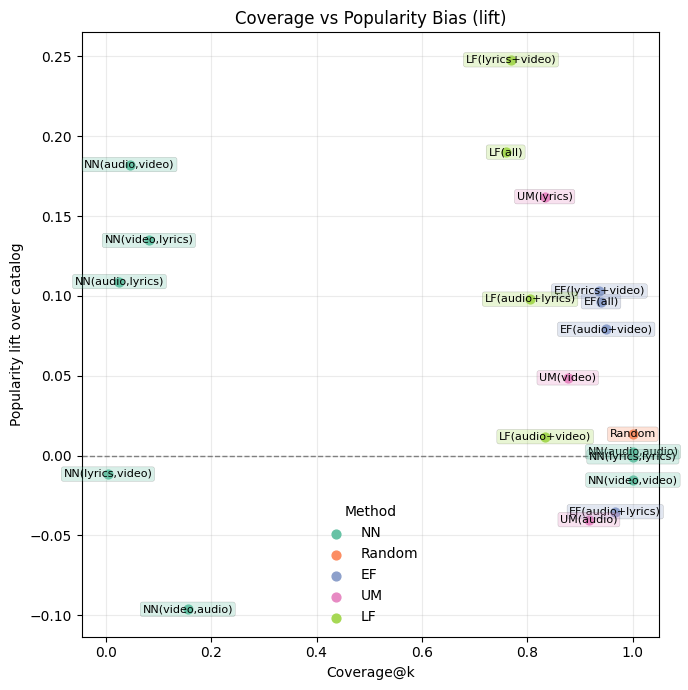

In [11]:
df_plot = df_beyond
df_plot = df_plot[df_plot["pop_lift"] <= 0.25]  # skip values outside this range to make plot more readable
df_plot = df_plot[~df_plot.index.str.contains("exp")]  # skip nn experiments
x = df_plot["coverage"]
y = df_plot["pop_lift"]

groups = df_plot.index.to_series().str.split("(", n=1).str[0]

unique_groups = groups.unique()
colors = plt.cm.Set2(range(len(unique_groups)))
color_map = dict(zip(unique_groups, colors))

plt.figure(figsize=(7, 7))

for g in unique_groups:
    mask = groups == g
    plt.scatter(
        x[mask],
        y[mask],
        s=40,
        color=color_map[g],
        label=g,
    )

for i, (name, row) in enumerate(df_plot.iterrows()):
    g = name.split("(", 1)[0]

    plt.annotate(
        name,
        (row["coverage"], row["pop_lift"]),
        fontsize=8,
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.2",
            fc=color_map[g],
            alpha=0.25,
            lw=0.3,
        ),
        arrowprops=dict(arrowstyle="-", lw=0.5, alpha=0.6)
    )

plt.xlabel("Coverage@k")
plt.ylabel("Popularity lift over catalog")
plt.title("Coverage vs Popularity Bias (lift)")
plt.axhline(0, linestyle="--", linewidth=1, color="gray")
plt.grid(alpha=0.25)
plt.legend(title="Method", frameon=False)
plt.tight_layout()
out_path = os.path.join("eval_images", "coverage_vs_pop.png")
plt.savefig(out_path, dpi=500, bbox_inches="tight")
plt.show()


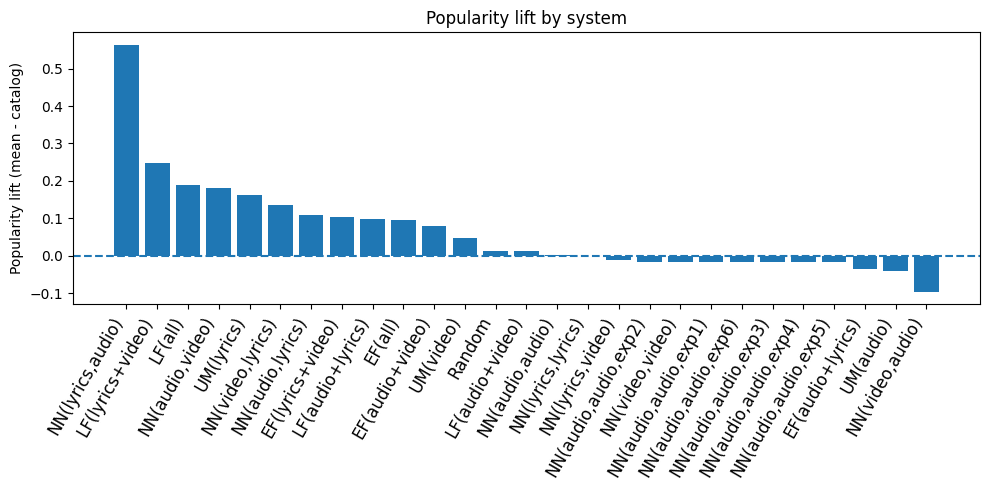

In [12]:
df_plot = df_beyond.sort_values("pop_lift", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df_plot.index, df_plot["pop_lift"])
plt.axhline(0, linestyle="--")
plt.xticks(rotation=60, ha="right",  fontsize=12)
plt.ylabel("Popularity lift (mean - catalog)")
plt.title("Popularity lift by system")
plt.tight_layout()

# save
out_path = os.path.join("eval_images", "poplift_by_system.png")
plt.savefig(out_path, dpi=500, bbox_inches="tight")


plt.show()



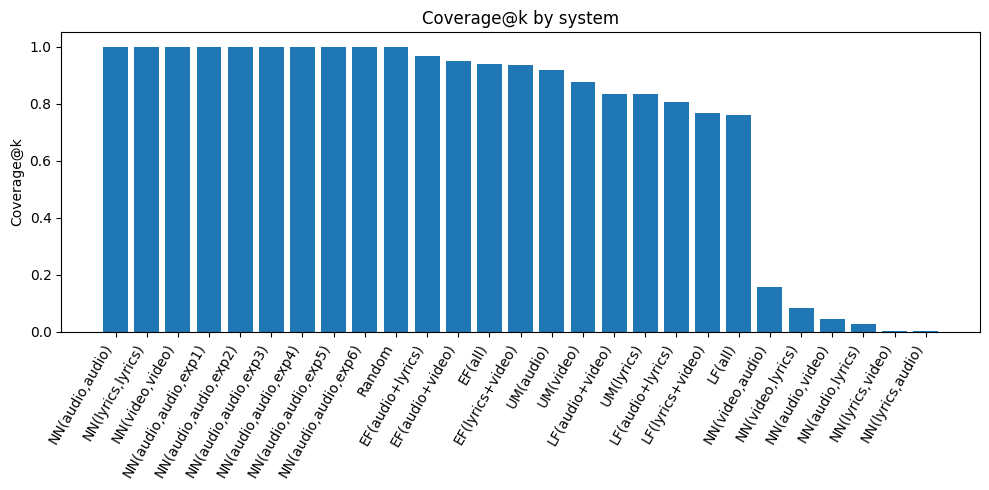

In [13]:

df_plot = df_beyond.sort_values("coverage", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df_plot.index, df_plot["coverage"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Coverage@k")
plt.title("Coverage@k by system")
plt.tight_layout()

# save
out_path = os.path.join("eval_images", "coverage_by_system.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")


plt.show()